## Convolutions and Spectroscopic Broadening

In class, we learned about two sources of broadening in molecular spectra:
* **Homogeneous Broadening** affects all molecules (or "sites") in the sample in the same way. For example, molecules usually have an excited state lifetime that (for a given type of molecule) is relatively uniform throughout a sample; this results in a *symmetric* homogeneous broadening of the absorption spectrum since it causes the polarization induced by an external field to decay with a characteristic time scale. Similarly, interactions between electronic and vibrational degrees of freedom give rise to *asymmetric* broadening of electronic absorption and fluorescence profiles. (This same asymmetry is what induces the Stokes shift between absorption and fluorescence). 
* **Inhomogeneous Broadening** results from variations (inhomogeneities) in the local environments of different molecules in a sample. For example, amide groups that accept strong hydrogen bonds from the surrounding solvent typically have lower C=O stretch frequencies than amide groups with weak hydrogen bonds. At any given instant, a solution of amide-containing molecules will feature some strongly hydrogen-bonded molecules and some weakly hydrogen-bonded molecules. This *inhomogeneity* of the amide environments gives rise to broadening in the bulk absorption spectrum, with weakly bonded molecules contributing to the "blue" edge of the spectrum and strongly bonded groups contributing to the "red" edge. 

In this exercise, we'll explore how inhomogeneous and homogeneous broadening mechanisms together determine spectroscopic line shapes. 

## Single-Site Spectrum ##

The phrase "single-site spectrum" is a sort of short-hand referring to the homogeneous line shape of a single molecule in a molecular ensemble. The cell below defines a simple function that approximates the single-site spectrum of an electronic oscillator as the sum of two terms: 
* The **Zero-Phonon Line** (ZPL) represents the purely electronic transition involving changes *only* in the electronic state. 
* The **Phonon Side Band** (PSB) represents coupling to low-frequency vibrational modes (phonons), i.e., transitions that change both the electronic and vibrational states. 
In the absorption spectrum plotted below, the ZPL is the sharp line near zero frequency. (Frequencies are measured relative to the purely electronic transition.) The PSB is the broad feature toward higher frequencies in absorption and toward lower frequencies in fluorescence. (This asymmetry is what gives rise to the Stokes shift in bulk spectra). 

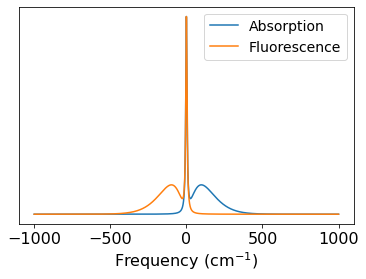

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython import display

def sspec(v,S):
    wZPL = 5.0
    vPSB = 50.0
    a = 3
    b = 1.0/vPSB
    ZPL = (1.0)/((math.pi*wZPL)*(1 + (v/wZPL)**2))
    PSB = (b**a)*(v**(a-1))*np.exp(-b*v)/math.gamma(a)*(v>0)
    
    return math.exp(-S)*ZPL + (1.0 - math.exp(-S))*PSB
    

vaxis = np.arange(-1000, 1000, 0.1)

plt.plot(vaxis, sspec(vaxis,1), label='Absorption')
plt.plot(vaxis, sspec(-vaxis,1), label='Fluorescence')
plt.xlabel('Frequency (cm$^{-1}$)', fontsize=16)
plt.xticks(np.arange(-1000,1001,500),fontsize=16)
plt.legend(fontsize=14)
plt.yticks([])
plt.show()

## Calculating a Convolution by Discrete Integration ##

In class, we noted that bulk spectra are calculated as the *convolution* of the single-site spectrum ($s(\omega)$) that captures homogeneous broadening with the site-distribution function (SDF or $p(\omega)$) that describes inhomogeneous broadening:$$ A(\omega) = [p*s](\omega) = \int_{-\infty}^{\infty} d\omega_o \; s(\omega - \omega_o) \, p(\omega_o).$$ Intuitively, you can understand this integral as a sum over contributions from the single-site absorption spectra ($s(\omega-\omega_o)$) of sites with all possible ZPL frequencies $\omega_o$, weighted by the probability ($p(\omega_o)$) that the given ZPL frequency occurs in the ensemble. 

In the code below, we calculate the bulk absorption spectrum $A(\omega)$ according to this formula directly, numerically integrating over the contributions from single-site spectra with all possible ZPL frequencies. 

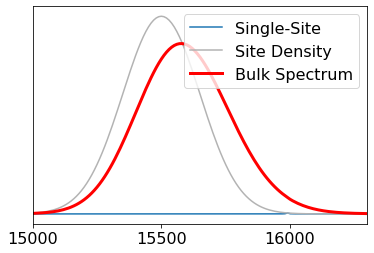

In [15]:
vstep = 10.0
vaxis = np.arange(15000.0, 16500.0, vstep)
vo = 15500
sig = 150

pdf = np.exp(-(vaxis-vo)**2/(2.0*sig**2))

plt.figure()
sspecline, = plt.plot(vaxis, 0*vaxis)
pdfline, = plt.plot(vaxis, pdf, color=[0.7,0.7,0.7])
totline, = plt.plot(vaxis, 0*vaxis, 'r', linewidth=3)

plt.legend(['Single-Site', 'Site Density', 'Bulk Spectrum'], fontsize=16)
plt.xlim([15000,16300])
plt.xticks(np.arange(15000,16301, 500), fontsize=16)
plt.yticks([])

vstop = 16000
nstop = np.argmin(np.abs(vstop-vaxis))

S = 1
SpTot = 0*vaxis
for n in range(0,len(vaxis[0:nstop])):
    vZPL = vaxis[n]
    Spn = sspec(vaxis - vZPL,S)
    SpTot += Spn*pdf[n]*vstep
    totline.set_ydata(SpTot)
    sspecline.set_ydata((Spn/np.max(Spn)*pdf[n]))
    display.display(plt.gcf())
    display.clear_output(wait=True)


## Calculating a Convolution by Random Sampling ##

For analytical purposes, the convolution integral defined above is essential to calculating spectroscopic line shapes. Numerically, however, we can calculate the line shape by another method: randomly selecting ZPL frequencies from the SDF profile, and adding the corresponding single-site spectra to the bulk absorption spectrum one-by-one. The code below illustrates this method, ultimately producing a bulk spectrum that (aside from a bit of noise) is identical to the convolution integral calculated in the last code block. 

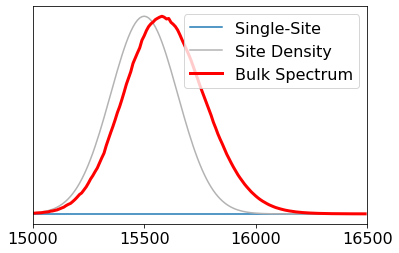

In [16]:
plt.figure()
sspecline, = plt.plot(vaxis, 0*vaxis)
pdfline, = plt.plot(vaxis, pdf, color=[0.7,0.7,0.7])
totline, = plt.plot(vaxis, 0*vaxis, 'r', linewidth=3)

plt.legend(['Single-Site', 'Site Density', 'Bulk Spectrum'], fontsize=16)
plt.xlim([15000,16500])
plt.xticks(np.arange(15000,16501, 500), fontsize=16)
plt.yticks([])


N = 100000
nUpdate = 1
SpTot = 0*vaxis
for n in range(0,N):
    vZPL = np.random.normal(vo,sig,1)
    Spn = sspec(vaxis - vZPL,S)
    SpTot += Spn
    
    if n%nUpdate==0:
        totline.set_ydata(SpTot/np.max(SpTot))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        nUpdate = math.floor(1.2*n + 1)
        #time.sleep(0.01)
    
        



## Calculating a Convolution by Fourier Transform ##

In high-performance computing, convolutions are most efficiently calculated using the convolution properties of Fourier transforms. The *Convolution Theorem* states that *the Fourier transform* of the *convolution* of two functions is simply the *product* of the *Fourier transforms* of each function. Applied to our spectrum calculation integral, this means that $$ \tilde A(t) = \tilde s(t) \, \tilde p(t),$$ where $\tilde A(t)$, $\tilde s(t)$, and $\tilde p(t)$ are the Fourier transforms of $A(\omega)$, $s(\omega)$, and $p(\omega)$. Conversely, then, we can calculate the *convolution* of $s(\omega)$ and $p(\omega)$ as the *inverse Fourier transform* of the product $\tilde s(t) p(t)$. 

The code below illustrates this use of this method to calculate the same absorption spectrum as in the earlier three cells. Although perhaps not as intuitively informative as the other approaches, it is by far the most numerically efficient. 

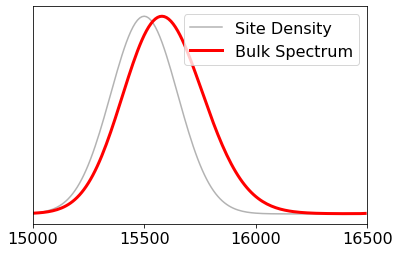

In [17]:
pdf = np.exp(-(vaxis-vo)**2/(2.0*sig**2))

# Generate a singlep-site spectrum centered in the window of interest
SSpec = sspec(vaxis - np.mean(vaxis),S)

# Normalize it
SSpec = SSpec/np.sum(SSpec)

# FFTshift it to peak at the first entry
SSpec = np.fft.fftshift(SSpec)

# Calculate the convolution
TotSpec = np.real(np.fft.ifft(np.fft.fft(pdf)*np.fft.fft(SSpec)))



plt.figure()
pdfline, = plt.plot(vaxis, pdf, color=[0.7,0.7,0.7])
totline, = plt.plot(vaxis, TotSpec/np.max(TotSpec), 'r', linewidth=3)

plt.legend(['Site Density', 'Bulk Spectrum'], fontsize=16)
plt.xlim([15000,16500])
plt.xticks(np.arange(15000,16501, 500), fontsize=16)
plt.yticks([])
plt.show()


## A Hole Burning Spectrum ##

Finally, we'll use the Fourier transform method of calculating the convolution to calculate the hole burning spectrum for our sample under weak excitation. In general, the hole burning spectrum $h(\omega)$ is calculated as the difference
$$h(\omega) = A'(\omega) - A(\omega),$$
where $A(\omega)$ is the original absorption spectrum of the sample, and $A'(\omega)$ is the absorption spectrum *after* excitation ("burning") by the laser. The modified profile $A'(\omega)$ is, in turn, calculated as the convolution
$$A'(\omega) = s(\omega) * p'(\omega),$$
where $p'(\omega)$ is the *modified* SDF for the system *after* "burning" by the laser. In the weak-excitation limit (and assuming that the new "post-burn" site energies are chosen randomly from the original SDF), this post-burn SDF is simply
$$p'(\omega) = p(\omega)(1 + \varepsilon) - \varepsilon \cdot p(\omega) s(\omega_{burn}-\omega)).$$ The first term here is just the original SDF for the system, reweighted by the total probability $\varepsilon$ that any given pigment in the ensemble has been burned. The second term represents the frequency-dependent probability that a pigment with ZPL frequency $\omega$ is "burned" by the laser, proportional to both the probability that a given pigment *has* ZPL frequency $\omega$ and the probability $s(\omega_{burn} - \omega)$ that a pigment with ZPL frequency $\omega$ is "burned" by the excitation laser with frequency $\omega_{burn}$. 

The code below uses these formulas to calculate the hole-burning spectrum for our system, for a laser excitation frequency of $\omega_{burn} = 15500$ cm$^{-1}$.

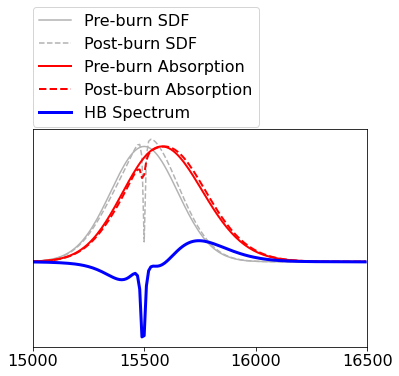

In [18]:
# Generate a singlep-site spectrum centered in the window of interest
SSpec = sspec(vaxis - np.mean(vaxis),S)

# Normalize it
SSpec = SSpec/np.sum(SSpec)

# FFTshift it to peak at the first entry
SSpec = np.fft.fftshift(SSpec)

# Original pdf
pdf = np.exp(-(vaxis-vo)**2/(2.0*sig**2))

# The excitation profile -- the probability that pigments at a given frequency are excited by the laser. 
ExcProf = sspec(15500-vaxis,S)*40

# Post-burn pdf: the distribution of site energies *after* laser excitation. 
pdfBurn = pdf - ExcProf + pdf*(np.sum(ExcProf/np.sum(pdf)))

# Calculate the convolution
PreBurnSpec = np.real(np.fft.ifft(np.fft.fft(pdf)*np.fft.fft(SSpec)))
PostBurnSpec = np.real(np.fft.ifft(np.fft.fft(pdfBurn)*np.fft.fft(SSpec)))

plt.figure()
pdfline, = plt.plot(vaxis, pdf, color=[0.7,0.7,0.7])
pdfline, = plt.plot(vaxis, pdfBurn, '--', color=[0.7,0.7,0.7])
totline, = plt.plot(vaxis, PreBurnSpec/np.max(PreBurnSpec), 'r', linewidth=2)
totline, = plt.plot(vaxis, PostBurnSpec/np.max(PostBurnSpec), 'r--', linewidth=2)
plt.plot(vaxis, (PostBurnSpec - PreBurnSpec)*5, 'b', linewidth=3)

plt.legend(['Pre-burn SDF', 'Post-burn SDF', 'Pre-burn Absorption', 'Post-burn Absorption', 'HB Spectrum'], fontsize=16, bbox_to_anchor=(0.7, 1.6))
plt.xlim([15000,16500])
plt.xticks(np.arange(15000,16501, 500), fontsize=16)
plt.yticks([])

plt.show()
